# SLU19 - Basic Workflow

In this notebook we will be covering the following:

- Notebook structure best practices
- Programming tips
- Basic pipelines
- Reading portions of a file

The goal here is to get some best practices established for basic projects using jupyter notebooks. More complicated projects will require more structure but for this academy these best practices should be enough.

This learning unit will serve more as a reference and guideline provider rather than something to teach new technical material. This notebook will be mostly text and although you might not see the point of it at first, as you hit problems and find yourself wasting time on little (or big) things here and there, try to remember back to this and see if there's something in here to help get yourself organized.

## Why learn workflow?

Because you want to spend your time doing science! not debugging stupid little things constantly and wasting your time!

Also, Data Science is largely an engineering discipline - you might as well just accept that right now. Writing code is an engineering practice and most data science is done with code these days. The most PURE industry research scientist I've spoken to works at Google's Deep Mind lab and he said that he is 50% software engineer!

Also...

## Jupyter is a terrible development environment

Because it isn't one! A development environment is centered around being able to organize your code in an effective way. Jupter is made primarily for rapid prototyping and communication, not software engineering so there are going to be significant drawbacks when it comes to organizing your code and you will need to be extremely anal about following best practices because Jupyter won't do any of it for you the way that a real IDE would.

## So why are we using jupyter?

Because our primary task in this academy is not to teach you how to be software engineers. It's to help you learn how to prototype and communicate as data scientists.

# Programming best practices

## Name things well

Remember that your code acts as communication material as much as it acts as instructions for a computer. Naming your functions and your variables well is key to this communication as well as preventing bugs in the future.


In [10]:
# this will confuse other people as well as future you
from sklearn.tree import DecisionTreeClassifier

a = pd.read_csv('data/titanic.csv')
b, c = a.drop('Survived', axis=1), a.Survived.copy()
d = pd.read_csv('data/titanic-test.csv')

# now let's preprocess and train

b_clean = b.select_dtypes(exclude='object').copy()
# note that you will want to impute with the median age from the training set
# and NOT the test set. This creates a few difficultites when trying to design
# around it
b_clean['Age'] = b_clean.Age.fillna(b_clean.Age.median())

d = RandomForestClassifier()
d.fit(b_clean, c);

## Use functions!

Don't be lazy with duplicating code. It is almost never worth it! The 5 minutes you will save by not taking common functionality and putting it into a function is almost never worth it because the confusion that comes afterward will always bite you.

Let's take a real-life example from SLU17 in which we need to read a dataframe and get the dummies. However, sometimes we will want to drop columns.

In [22]:
# here is the first case where we don't need to drop any columns

_df = pd.read_csv('data/titanic.csv')

# Split the factors and the target
X, y = _df.drop('Survived', axis=1), _df['Survived']

# take special note of this call!
X = pd.get_dummies(X, dummy_na=True).fillna(-1)

As we remember, we decided that there were useless features so we wanted to drop some. One way we could achieve this is to copy-paste the cell into another one and the modify it:

In [23]:
_df = pd.read_csv('data/titanic.csv')

##################
# NEW CODE
drop_columns = [
    'Ticket',
    'PassengerId'
]

# now drop any columns that are specified as needing to be dropped
for colname in drop_columns:
    _df = _df.drop(colname, axis=1)
# END NEW CODE
##################

for colname in categoricals:
    if colname in drop_columns:
        continue
    _df[colname] = _df[colname].fillna('null').astype('category')


# Split the factors and the target
X, y = _df.drop('Survived', axis=1), _df['Survived']

# take special note of this call!
X = pd.get_dummies(X, dummy_na=True).fillna(-1)

This makes my eyes bleed! Arrrggghhh it hurts! One of the main reasons this is such rough times is that is such rough times is imagine that you want to change the `fillna(-1)` to `fillna(0)`. You now have to change this in two places. Now imagine that you have duplicated this cell in 10 different places, you're going to have to remember to change this in 10 different places and you're going to have a terrible time.

What's the right thing to do here? Put it in a function! It doesn't have to be anything special and as you all passed the test, we know you all know how to write function so NO EXCUSES. Here's what my function for this ended up looking like:

In [24]:
def read_and_get_dummies(drop_columns=[]):
    # when working inside of functions, always call your dataframe
    # _df so that you know you're never using any from the outside!
    _df = pd.read_csv('data/titanic.csv')

    # now drop any columns that are specified as needing to be dropped
    for colname in drop_columns:
        _df = _df.drop(colname, axis=1)
    
    for colname in categoricals:
        if colname in drop_columns:
            continue
        _df[colname] = _df[colname].fillna('null').astype('category')


    # Split the factors and the target
    X, y = _df.drop('Survived', axis=1), _df['Survived']

    # take special note of this call!
    X = pd.get_dummies(X, dummy_na=True).fillna(-1)

    return _df, X, y

Which would take the previous two cells to this niceness:

In [25]:
df_train, X, y = read_and_get_dummies()

In [26]:
drop_columns = [
    'Ticket',
    'PassengerId'
]
df_train, X, y = read_and_get_dummies(drop_columns)

Wow, huge improvement!

## When writing functions

1. If you take a parameter that is a dataframe, always name if `_df`
1. Outside of functions, never name a dataframe `_df`
1. Inside of functions, never name a dataframe `df`

Why you ask? Let's see!

In [28]:
# you're working in a notebook with the following dataframe

df = pd.DataFrame({
    'f_1': [1, 2, 3, 4],
    'f_2': [4, 5, 6, 7],
    'age': [50, 60, 70, 80],
    'sex': ['m', 'f', 'f', 'm']
})

# say you have a convenience function to drop all object columns
def drop_cats(df):
    return df.drop(df.select_dtypes(include=['object']).columns, axis=1)

In [29]:
drop_cats(df)

,age,f_1,f_2
0,50,1,4
1,60,2,5
2,70,3,6
3,80,4,7


Then you make another version of the function because you remember to name the dataframe parameter `_df`

In [30]:
cats_and_dogs = pd.DataFrame({
    'cat': ['hello'],
    'dog': [1]
})

def drop_cats(_df):
    return df.drop(df.select_dtypes(include=['object']).columns, axis=1)

drop_cats(cats_and_dogs)

,age,f_1,f_2
0,50,1,4
1,60,2,5
2,70,3,6
3,80,4,7


Woah this was not expected! Easy fix though: when working on functions, always use `_df` from the very beginning when inside of the function and then never use `_df` as a variable name outside of the function!

## Immutability is key!

If you pass a dataframe into a function, NEVER EVER EVER will you want to change the dataframe that was passed in. This causes chaos in the world. A few rules to adhere to when doing this are the following:

1. Never use inplace=True
1. If you have a function that takes a dataframe as an argument and returns a modified version of it, always copy it at the beginning of the function and make your changes to that copy.

Why? Let's see an example.

Say I want a function that drops all columns that start with 'f_':

In [31]:
def drop_f(_df):
    
    cols_to_drop = []
    for colname in _df.columns:
        if colname.startswith('f_'):
            cols_to_drop.append(colname)

    _df.drop(cols_to_drop, axis=1, inplace=True)
    
    return _df

In [32]:
df = pd.DataFrame({
    'f_1': [1, 2, 3, 4],
    'f_2': [4, 5, 6, 7],
    'age': [50, 60, 70, 80],
    'sex': ['m', 'f', 'f', 'm']
})

In [33]:
# now let's drop the f_
df_no_f = drop_f(df)
df_no_f

,age,sex
0,50,m
1,60,f
2,70,f
3,80,m


Great success! Now let's check out the original df

In [34]:
df

,age,sex
0,50,m
1,60,f
2,70,f
3,80,m


Wait, we never said to drop it from the original dataframe but it happened anyway! What the heck?

That's because we violated the rules and use inplace=True nor did we make a copy! Let's rewrite this function to be a bit nicer:

In [35]:
def drop_f(_df):
    
    _df = _df.copy()
    
    cols_to_drop = []
    for colname in _df.columns:
        if colname.startswith('f_'):
            cols_to_drop.append(colname)

    _df = _df.drop(cols_to_drop, axis=1)
    
    return _df

df = pd.DataFrame({
    'f_1': [1, 2, 3, 4],
    'f_2': [4, 5, 6, 7],
    'age': [50, 60, 70, 80],
    'sex': ['m', 'f', 'f', 'm']
})

In [36]:
df_no_f = drop_f(df)
df_no_f

,age,sex
0,50,m
1,60,f
2,70,f
3,80,m


In [37]:
df

,age,f_1,f_2,sex
0,50,1,4,m
1,60,2,5,f
2,70,3,6,f
3,80,4,7,m


Much better!

Now at this point you might be saying: why not just pick one of the two rules, either of those would have worked. That's totally true, in this case. However, all good programmers should adhere to best practices and the problem with `inplace=True` is that it changes the `drop()` API by making it return `None`.

This WILL CAUSE CONFUSTION! If you are used to using `inplace=True` and another person you are working with is not used to using it, I can guarantee that you'll copy the person's code at least once and then wonder why this doesn't work:

In [38]:
df = pd.DataFrame({
    'f_1': [1, 2, 3, 4],
    'f_2': [4, 5, 6, 7],
    'age': [50, 60, 70, 80],
    'sex': ['m', 'f', 'f', 'm']
})
no_f = df.drop('f_1', inplace=True, axis=1)
no_f.head()

AttributeError: 'NoneType' object has no attribute 'head'

It is for these reasonas well as many others that immutability is preferable not matter what language you're working in. Trust me on this one!

# Notebook Best Practices

## Imports up top!

You should always have your imports up at the top of the file. Anyone that looks at your notebook should get an idea of the tools that you are using IMMEDIATELY with a glance as soon as opening your notebook.

And help your own sanity as well! You don't want to loose a key import during a cleanup and then when someone fires up your notebook for the first time and runs it, there's an import missing. This happens ALL the time, so you need to minimize as much as possible these issues.

In [1]:
# even if you don't use an import until way later on in the file, put your imports here!
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import Imputer

## Organize your directory

1. All your notebooks should be in the same directory.
1. You should create a data directory and put all of your data in it
1. If you have images or other media, put it in a media directory.

Here is an example directory structure from SLU17


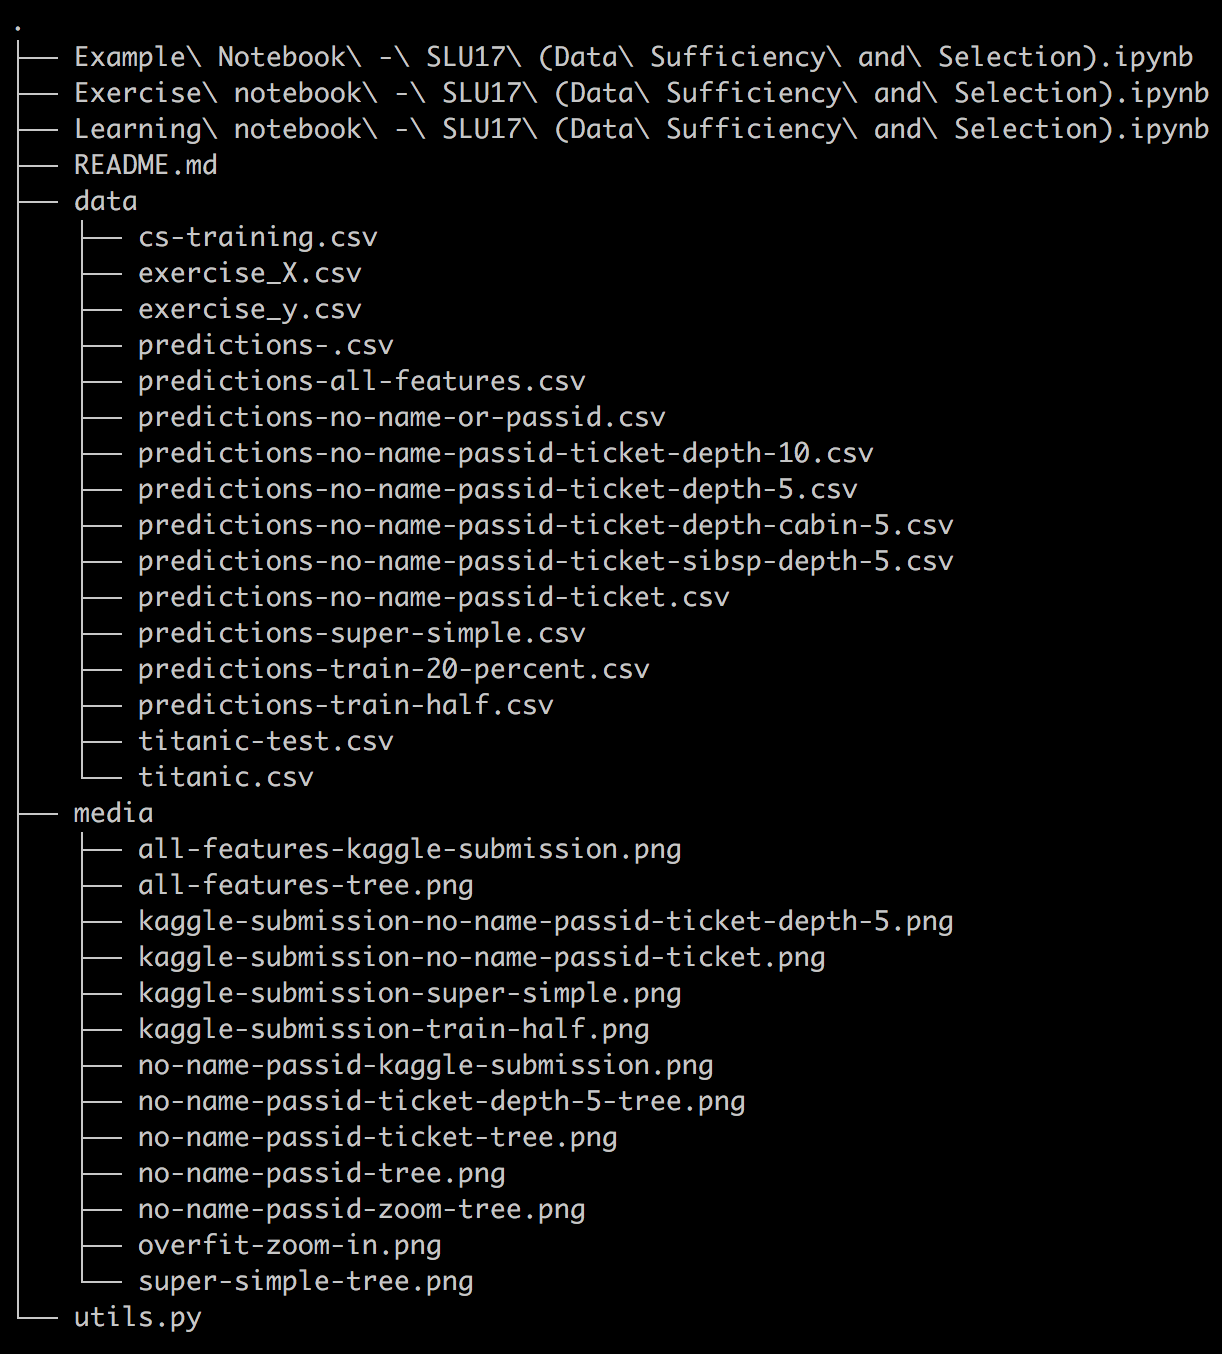

In [3]:
Image('media/directory-structure.png', width=500)

## When writing functions

1. Keep them close to the cell where you are testing it at first
1. When they are stabilizing, move them to the top of the notebook
1. When you are starting to use them a lot, move them into a utils.py file and import from there

You can see many examples of this in the files in this repository, follow them!

For example:

In [4]:
df = pd.DataFrame({
    'int_col': [1, 2, 3],
    'float_col': [1.0, 2.0, 3.0],
    'cat_col_1': pd.Series(['a', 'b', 'c'], dtype='category'),
    'cat_col_2': pd.Series(['d', 'e', 'f'], dtype='category')
})

df_medium = pd.DataFrame({
    'int_col': [1, 2, 3],
    'float_col': [1.0, 2.0, 3.0],
    'cat_col_1': pd.Series(['a', 'b', 'c'], dtype='category'),
    'cat_col_2': pd.Series(['d', 'e', 'f'], dtype='category'),
    'last_col': [9, 10, 00]
})

df_full = pd.DataFrame({
    'int_col': [1, 2, 3],
    'float_col': [1.0, 2.0, 3.0],
    'cat_col_1': pd.Series(['a', 'b', 'c'], dtype='category'),
    'cat_col_2': pd.Series(['d', 'e', 'f'], dtype='category'),
    'int_col_2': [1, 2, 3],
    'float_col_2': [1.0, 2.0, 3.0],
    'cat_col_3': pd.Series(['a', 'b', 'c'], dtype='category'),
    'cat_col_4': pd.Series(['d', 'e', 'f'], dtype='category')
})

In [5]:
# I need a new function called get_categoricals

def get_categoricals(_df):
    return _df.select_dtypes(include=['category'])

# and I'm going to use it here

get_categoricals(df)
get_categoricals(df_full)
get_categoricals(df_medium)

,cat_col_1,cat_col_2
0,a,d
1,b,e
2,c,f


Now that I've finished with the function and it's all tested, I need to move the function up to the top of the file so that the cell where you are doing the actual work is much cleaner. Now this is only with a single-line function and you can already seem the improvement.

In [6]:
# much cleaner, right?
cat_columns = get_categoricals(df)
cat_columns_full_dataset = get_categoricals(df_full)
cat_columns_medium_dataset = get_categoricals(df_medium)

If I do this enough times, I'll get a notebook call that contains my functions up top that looks like this:

In [7]:
categoricals = [
    'PassengerId',
    'Name',
    'Ticket',
    'Sex',
    'Cabin',
    'Embarked',
]

# Here are a few functions that we will use to do our proof of concepts
# around training and testing for kaggle submissions for the titanic
# competition.

# The reason that we need to have these functions they way they are
# is to manage the preprocessing of the features the same for the 
# training and test set. Don't worry too much about exactly what's
# going on in these functions right now but rather focus on the concepts
# that are being covered after this in the notebook.


def read_and_get_dummies(drop_columns=[]):
    # when working inside of functions, always call your dataframe
    # _df so that you know you're never using any from the outside!
    _df = pd.read_csv('data/titanic.csv')

    # now drop any columns that are specified as needing to be dropped
    for colname in drop_columns:
        _df = _df.drop(colname, axis=1)
    
    for colname in categoricals:
        if colname in drop_columns:
            continue
        _df[colname] = _df[colname].fillna('null').astype('category')


    # Split the factors and the target
    X, y = _df.drop('Survived', axis=1), _df['Survived']

    # take special note of this call!
    X = pd.get_dummies(X, dummy_na=True).fillna(-1)

    return _df, X, y
    


def train_and_test(drop_columns=[], max_depth=None, test_size=0.2):
    """
    Train a decision tree and return the classifier, the X_train,
    and the original dataframe so that they can be used on the test
    set later on.
    """
    
    _df, X, y = read_and_get_dummies(drop_columns=drop_columns)
    
    # Now let's get our train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=1, test_size=test_size)
    
    X_train, X_test, y_train, y_test
    
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
    clf.fit(X_train, y_train)
    
    score = accuracy_score(y_test, clf.predict(X_test))
    print('X_test accuracy {}'.format(score))
    print('X_train shape: {}'.format(X_train.shape))
    
    return X_train, _df, clf


def produce_test_predictions(train_df, clf, drop_columns=[]):
    _df = pd.read_csv('data/titanic-test.csv')
    
    for colname in drop_columns:
        _df = _df.drop(colname, axis=1)
        
    for colname in categoricals:
        if colname in drop_columns:
            continue
        _df[colname] = _df[colname].fillna('null')
        _df[colname] = pd.Categorical(
            _df[colname],
            categories=train_df[colname].cat.categories
        )
        
    X = pd.get_dummies(_df, dummy_na=True).fillna(-1)
    
    return pd.DataFrame({
        'PassengerId': pd.read_csv('data/titanic-test.csv').PassengerId,
        'Survived': pd.Series(clf.predict(X))
    })


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test Set score")

    plt.legend(loc="best")
    return plt


GAAAH! It's too much! I have to scroll for a mile just to get to the first informative part of the notebook! 

At this point, move it into a utils.py file

## Caveat - changes to utils.py require a reload

This is a huge bummer: jupyter will not automatically pick up on changes to your utils.py
file without being told to reload them. This means that you should use the autoreload. The way you should use it is like the following:

In [8]:
# above your import cell, do this
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
# from utils import say_hi

# them in your import cell, include the %autoreload 2 at the bottom of it
% autoreload 2

Then if you make changes to utils.py you just need to re-run the import cell and you are good to go with the updated versions of all your functions.

## Periodically restart your notebooks

Because notebooks are continuously running processes, it's REALLY easy to leave stuff lying around that you can't see any more. I can't really show you an example in this notebook because it would require a live demo but let's do a little thought experiment:

In [10]:
# version 1 of this cell
a_var = 10
b_var = 20

Now let's say that I don't need the `b_var` any more so I delete it from the cell

In [11]:
# version 2 of this cell (imagine that I changed the original one)
a_var = 20

Now we are left with a notebook that doesn't have the `b_var` anywhere in it. However when I execute the following:

In [12]:
b_var

20

It's still here! Now this is sloppy and unfortunate and a perfect example of why juypter notebook is not an IDE. `b_var` does not exist anywhere in the notebook yet if I reference it, it still exists!

The solution? Restart the notebook! If you do this and then run the `b_var` cell again, it will error as it should:

In [13]:
b_var

20

## Restart and re-run the entire notebook before calling it done

This is a huge one! Because of un-intended side effects of how jupyter works, it is inevitable that different cells will have been run with different versions of the notebook. If you have a cell working with an old version of a dataframe or function it could be displaying the wrong output. Then if you deliver this to someone, and they re-run it without changing ANY code, you're going to run into problems.


For example:

In [19]:
def say_hello():
    print('whaddap')

In [20]:
say_hello()

whaddap


Now change the function and run it again in a different cell:

In [16]:
say_hello()

whaddap mah homie


You can imagine that if someone comes along and sees this they will be MASSIVELY confused. It's easy to fix this, just restart the notebook and run everything again!

# Scikit pipelines

Sooner than later, you will run into the problem of having to do duplicate pre-processing for a training and a test set or for different folds in cross validation. This can be a huge pain the the butt and can result in duplicated code or functions that have a crazy amount of arguments. 

Let's start of with a bit of motivation by looking at the titanic dataset where we will drop all categorical features and fill the nulls on the rest with the median




In [40]:
train_df = pd.read_csv('data/titanic.csv')
X_train, y_train = train_df.drop('Survived', axis=1), train_df.Survived.copy()
X_test = pd.read_csv('data/titanic-test.csv')

# now let's preprocess and train

X_train_clean = X_train.select_dtypes(exclude='object').copy()
# note that you will want to impute with the median age from the training set
# and NOT the test set. This creates a few difficultites when trying to design
# around it
X_train_clean['Age'] = X_train_clean.Age.fillna(X_train_clean.Age.median())

clf = RandomForestClassifier()
clf.fit(X_train_clean, y_train)

# then to test, we will need to do the same set of preprocessing

X_test_clean = X_test.select_dtypes(exclude='object').copy()
X_test_clean['Age'] = X_test_clean.Age.fillna(X_train_clean.Age.median())
# now it turns out that X_test_clean has a column with nulls that X_test
# didn't have so the preprocessing would have to be a bit different

# Now there are some nulls in Fare for the test set that were not 
# in the training set.
X_test_clean['Fare'] = X_test_clean.Fare.fillna(X_train.Fare.median())

preds = clf.predict_proba(X_test_clean)[:, 1]

It's totally true that we could write a few functions to take care of this, but scikit already provides some tooling that end up being cleaner using [pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

What is a pipeline? Pretty simple: it's a set of steps that has a model at the end of it. It implements the same API as the models (has `predict` and/or `predict_proba`) but it applies each of the steps before calling the model with the input!

Let's see how to use one to simplify the code we just looked at

In [41]:
train_df = pd.read_csv('data/titanic.csv')
X_train, y_train = train_df.drop('Survived', axis=1), train_df.Survived.copy()
X_test = pd.read_csv('data/titanic-test.csv')

# for some cases, we will want to create our own pipeline step
# this provides a lot of flexibility!
class RemoveObjectColumns(TransformerMixin):
    
    def transform(self, X, *_):
        return X.select_dtypes(exclude='object').copy()
    
    def fit(self, *_):
        return self

# now let's make the pipeline
pipeline = make_pipeline(
    RemoveObjectColumns(),
    # it's cool how scikit already has a mean imputer ready to go!
    Imputer(strategy='mean'),
    RandomForestClassifier()
)

# No need for us to manually preprocess the X_train at all
pipeline.fit(X_train, y_train)

# Same thing for X_test
probas = pipeline.predict_proba(X_test)

These can take a bit of time to learn how to use and they do have some strange behavior in some cases so be a bit patient with them - the work pays off!

# Handeling large datasets on your machine

Okay say that your working with a fairly large dataset and it's taking a while to train. Furthermore may the full dataset doesn't fit into memory on your machine but you still want to do some EDA as well as train a model. There are a few ways to do this

1. Only read part of the file into memory
1. If you are able to read the whole thing into memory but don't want to be working with it the entire time, you can take a sample of it while doing your work

In [42]:
# only read the first 10 rows
pd.read_csv('data/titanic.csv', nrows=10).shape

(10, 12)

In [43]:
# read the whole thing into memory but then sample only a portions of it
# this is okay if you are able to read the whole thing into memory and just
# want to speed up training or something like that 
pd.read_csv('./data/titanic.csv').sample(frac=.10).shap

(89, 12)

If you want to take a random sample from what is actually on the disk, there are a few ways to do this
and none of them are really great. Here are some suggestions if you ever run into this

https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa